In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, GRU, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

2025-09-11 18:16:54.867996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding='latin', header=None)

df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

lab_to_sentiment = {0:"Negative", 4:"Positive"}

def label_decoder(label):
  return lab_to_sentiment[label]

df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

df.head()

,sentiment,text
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


In [4]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 100

In [5]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=7)

print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [7]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 100)
Testing X Shape: (320000, 100)


In [8]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [9]:
GLOVE_EMB = 'data/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [10]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [11]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [12]:
embedding_layer = Embedding(
    vocab_size,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

/home/andrew/Projects/School/CS_574/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1757636270.505480 3732796 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5345 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:0a:00.0, compute capability: 8.9


In [13]:
# sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# embedding_sequences = embedding_layer(sequence_input)

# x = SpatialDropout1D(0.2)(embedding_sequences)
# x = Conv1D(64, 5, activation='relu')(x)
# x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)

# outputs = Dense(1, activation='sigmoid')(x)

# model = Model(sequence_input, outputs)

In [ ]:

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_sequences = embedding_layer(sequence_input)

x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu', padding='same')(x)
x = Conv1D(128, 5, activation='relu', padding='same')(x) # additional layer
x = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(x) # additional layer
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, outputs)

In [15]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])

ReduceLROnPlateau = ReduceLROnPlateau(
    factor=0.1,
    min_lr=0.01,
    monitor='val_loss',
    verbose=1
)

In [ ]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [17]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_data=(x_test, y_test), 
    callbacks=[ReduceLROnPlateau, early_stopping]
)

Epoch 1/10


2025-09-11 18:17:51.843390: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 512000000 exceeds 10% of free system memory.
2025-09-11 18:17:58.284880: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 430s 339ms/step - accuracy: 0.7462 - loss: 0.5102 - val_accuracy: 0.7705 - val_loss: 0.4756 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 422s 338ms/step - accuracy: 0.7686 - loss: 0.4789 - val_accuracy: 0.7763 - val_loss: 0.4662 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 431s 344ms/step - accuracy: 0.7742 - loss: 0.4691 - val_accuracy: 0.7785 - val_loss: 0.4620 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 434s 348ms/step - accuracy: 0.7780 - loss: 0.4632 - val_accuracy: 0.7799 - val_loss: 0.4597 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 432s 346ms/step - accuracy: 0.7811 - loss: 0.4584 - val_accuracy: 0.7791 - val_loss: 0.4619 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 437s 350ms/step - accuracy: 0.7831 - loss: 0.4547 - val_accuracy: 0.7803 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 435s 348ms/step - acc

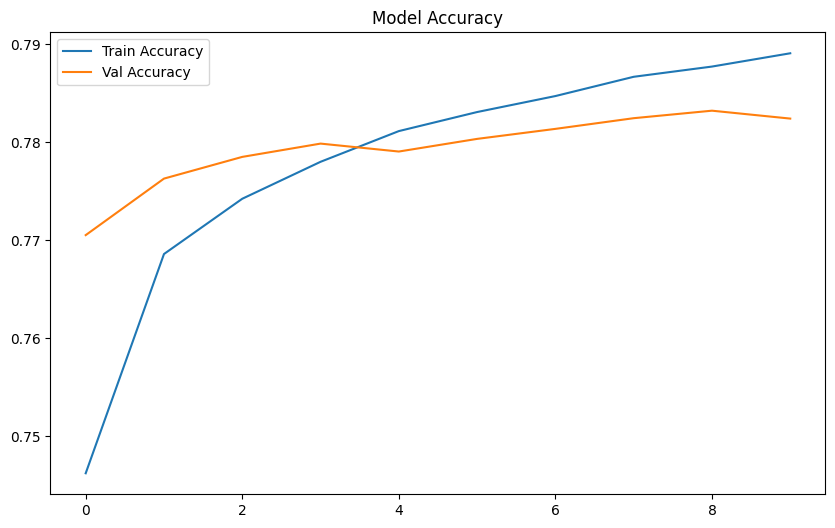

In [20]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title("Model Accuracy")

plt.legend(['Train Accuracy', 'Val Accuracy'])

plt.savefig("accuracy_10_epochs.png")
plt.show()

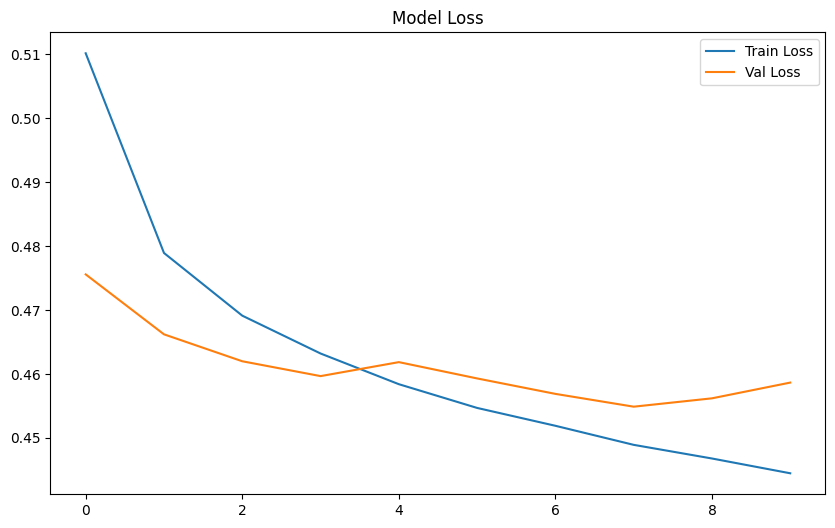

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')

plt.legend(['Train Loss', 'Val Loss'])

plt.savefig("loss_10_epochs.png")
plt.show()